## Objective
HR team wants to utilize the stored data to make a model, that will predict if a person is eligible for promotion or not.



## Data Dictionary:
- employee_id: Unique ID for the employee
- department: Department of employee
- region: Region of employment (unordered)
- education: Education Level
- gender: Gender of Employee
- recruitment_channel: Channel of recruitment for employee
- no_ of_ trainings: no of other trainings completed in the previous year on soft skills, technical skills, etc.
- age: Age of Employee
- previous_ year_ rating: Employee Rating for the previous year
- length_ of_ service: Length of service in years
- awards_ won: if awards won during the previous year then 1 else 0
- avg_ training_ score: Average score in current training evaluations
- is_promoted: (Target) Recommended for promotion

In [175]:
# To help with reading and manipulation of data
import numpy as np
import pandas as pd

# To help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# To split the data
from sklearn.model_selection import train_test_split

# To impute missing values
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To help with model building
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)

from xgboost import XGBClassifier

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To tune a model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# To get different performance metrics
import sklearn.metrics as metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    recall_score,
    accuracy_score,
    precision_score,
    f1_score,
)


# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [189]:
df = pd.read_csv('./employee_promotion (1).csv')
# We can drop Region and Employee ID as they don't relate to employee performance

employee_df = df.copy()
employee_df.drop(columns=['employee_id','region'],inplace=True)

employee_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   department            54808 non-null  object 
 1   education             52399 non-null  object 
 2   gender                54808 non-null  object 
 3   recruitment_channel   54808 non-null  object 
 4   no_of_trainings       54808 non-null  int64  
 5   age                   54808 non-null  int64  
 6   previous_year_rating  50684 non-null  float64
 7   length_of_service     54808 non-null  int64  
 8   awards_won            54808 non-null  int64  
 9   avg_training_score    52248 non-null  float64
 10  is_promoted           54808 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 4.6+ MB


In [122]:
employee_df.head()

,department,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
0,Sales & Marketing,Master's & above,f,sourcing,1,35,5.0,8,0,49.0,0
1,Operations,Bachelor's,m,other,1,30,5.0,4,0,60.0,0
2,Sales & Marketing,Bachelor's,m,sourcing,1,34,3.0,7,0,50.0,0
3,Sales & Marketing,Bachelor's,m,other,2,39,1.0,10,0,50.0,0
4,Technology,Bachelor's,m,other,1,45,3.0,2,0,73.0,0


In [123]:
employee_df.describe().T

,count,mean,std,min,25%,50%,75%,max
no_of_trainings,54808.0,1.253011,0.609264,1.0,1.0,1.0,1.0,10.0
age,54808.0,34.803915,7.660169,20.0,29.0,33.0,39.0,60.0
previous_year_rating,50684.0,3.329256,1.259993,1.0,3.0,3.0,4.0,5.0
length_of_service,54808.0,5.865512,4.265094,1.0,3.0,5.0,7.0,37.0
awards_won,54808.0,0.023172,0.150450,0.0,0.0,0.0,0.0,1.0
avg_training_score,52248.0,63.712238,13.521910,39.0,51.0,60.0,77.0,99.0
is_promoted,54808.0,0.085170,0.279137,0.0,0.0,0.0,0.0,1.0


In [124]:
employee_df.describe(include='object').T

,count,unique,top,freq
department,54808,9,Sales & Marketing,16840
education,52399,3,Bachelor's,36669
gender,54808,2,m,38496
recruitment_channel,54808,3,other,30446


In [125]:
for i in employee_df.describe(include=["object"]).columns:
    print("Unique values in", i, "are :")
    print(employee_df[i].value_counts())
    print("-" * 50)

Unique values in department are :
Sales & Marketing    16840
Operations           11348
Technology            7138
Procurement           7138
Analytics             5352
Finance               2536
HR                    2418
Legal                 1039
R&D                    999
Name: department, dtype: int64
--------------------------------------------------
Unique values in education are :
Bachelor's          36669
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64
--------------------------------------------------
Unique values in gender are :
m    38496
f    16312
Name: gender, dtype: int64
--------------------------------------------------
Unique values in recruitment_channel are :
other       30446
sourcing    23220
referred     1142
Name: recruitment_channel, dtype: int64
--------------------------------------------------


In [126]:
# For flexibility of choosing models, we will switch everything to numericals
for var in employee_df.select_dtypes(include=object):
    vals = sorted(list(employee_df[var].dropna().unique()))
    nums = np.arange(0,len(vals)+1)
    replace = dict(zip(vals,nums))
    print('The data dictionary for turning everything to numerical is')
    print(replace)
    employee_df.replace({var:replace},inplace=True)

employee_df.head()      

The data dictionary for turning everything to numerical is
{'Analytics': 0, 'Finance': 1, 'HR': 2, 'Legal': 3, 'Operations': 4, 'Procurement': 5, 'R&D': 6, 'Sales & Marketing': 7, 'Technology': 8}
The data dictionary for turning everything to numerical is
{"Bachelor's": 0, 'Below Secondary': 1, "Master's & above": 2}
The data dictionary for turning everything to numerical is
{'f': 0, 'm': 1}
The data dictionary for turning everything to numerical is
{'other': 0, 'referred': 1, 'sourcing': 2}


,department,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted
0,7,2.0,0,2,1,35,5.0,8,0,49.0,0
1,4,0.0,1,0,1,30,5.0,4,0,60.0,0
2,7,0.0,1,2,1,34,3.0,7,0,50.0,0
3,7,0.0,1,0,2,39,1.0,10,0,50.0,0
4,8,0.0,1,0,1,45,3.0,2,0,73.0,0


# EDA

In [127]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_violin, ax_box, ax_hist) = plt.subplots(
        nrows=3,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.50,0.5, 0.75)},
        figsize=figsize,
    )  
    # creating the 2 subplots    
    sns.violinplot(data=data, x=feature ,ax=ax_violin, color="blue")

    sns.boxplot(data=data, x=feature, ax=ax_box, showmeans=True, color="violet")  
    # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist
    )  # For histogram
    ax_hist.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

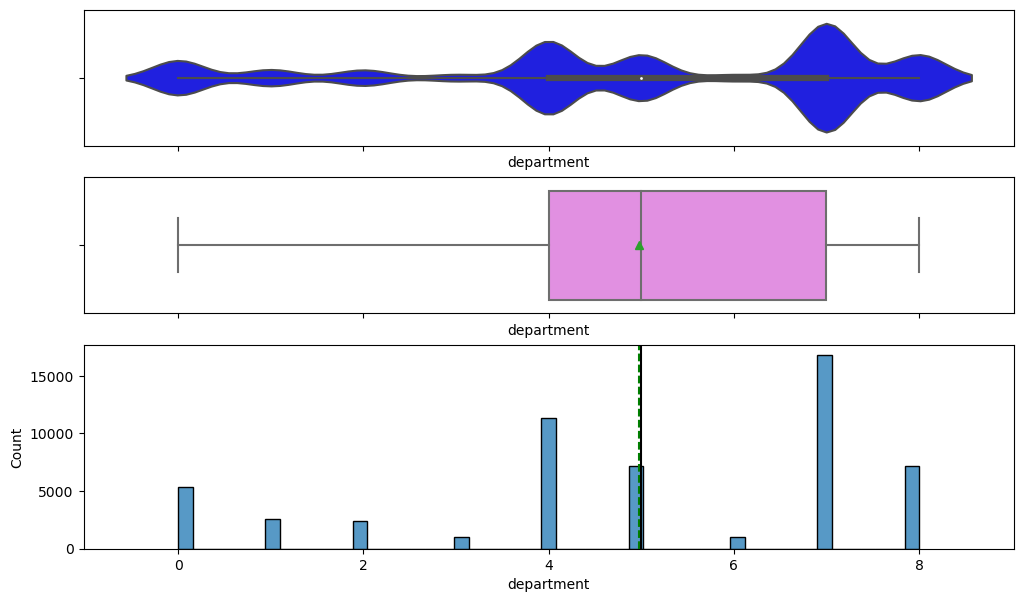

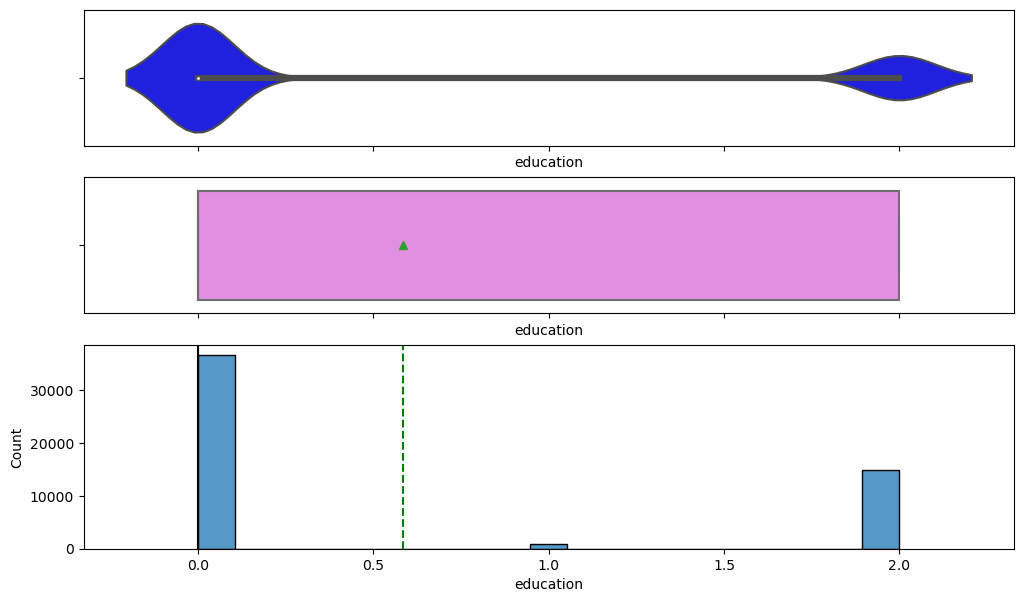

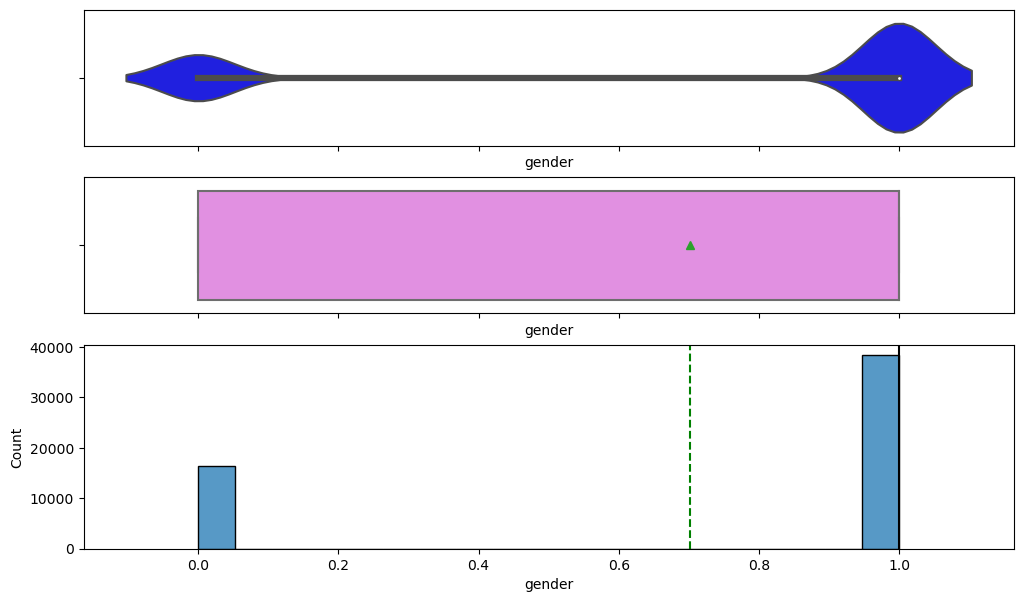

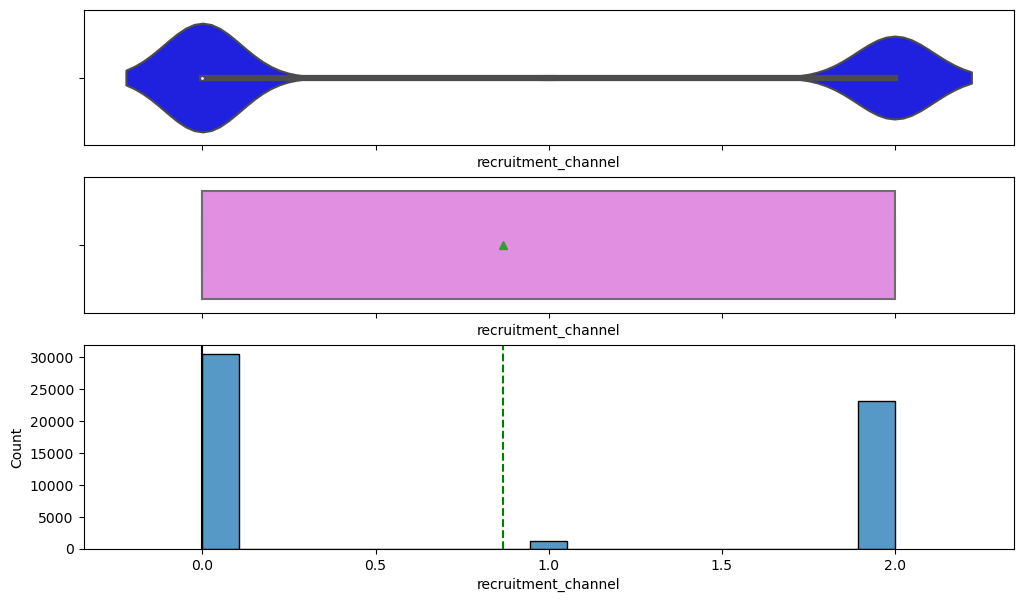

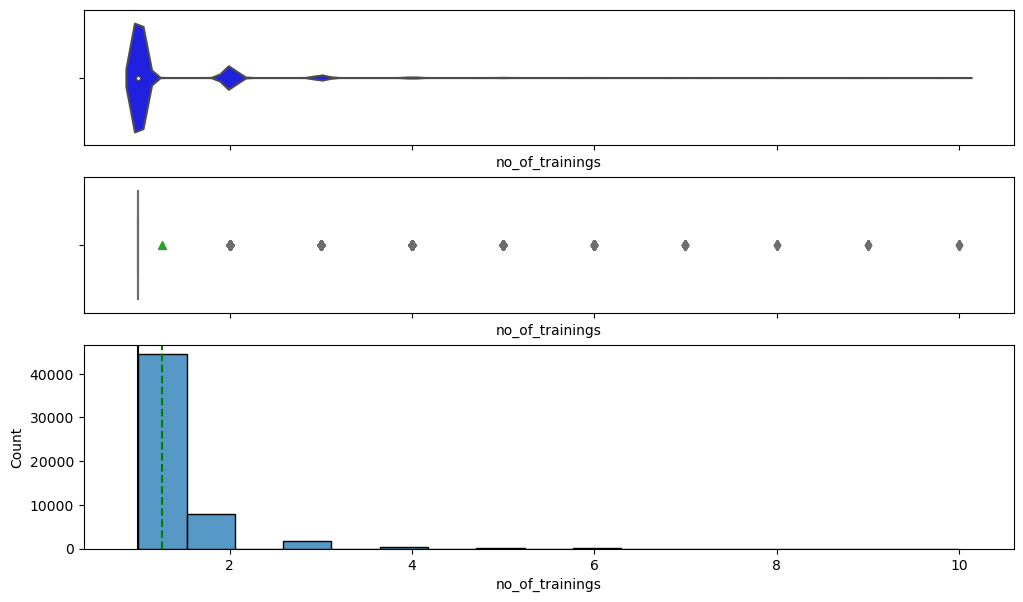

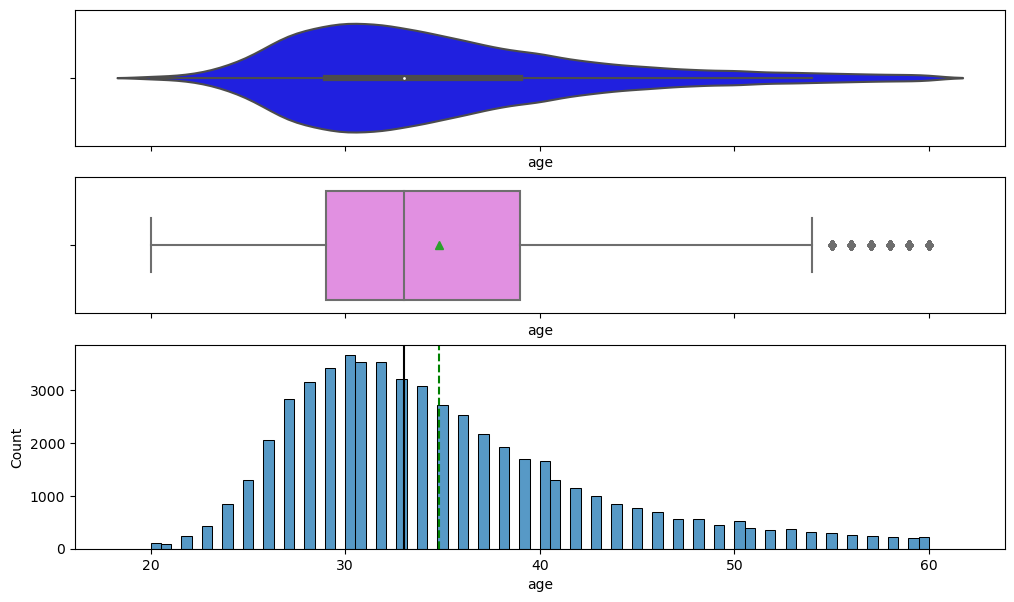

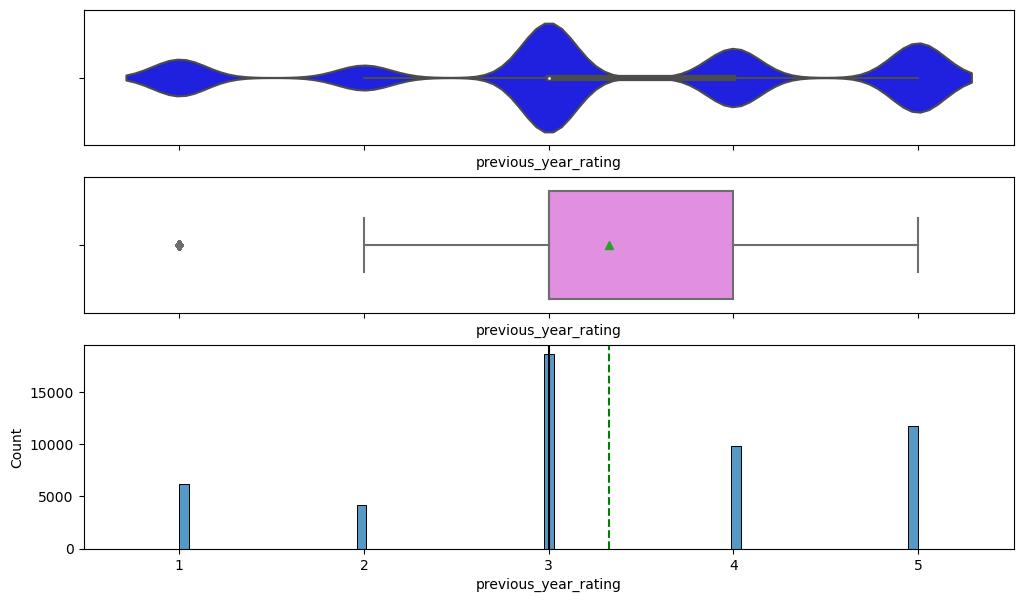

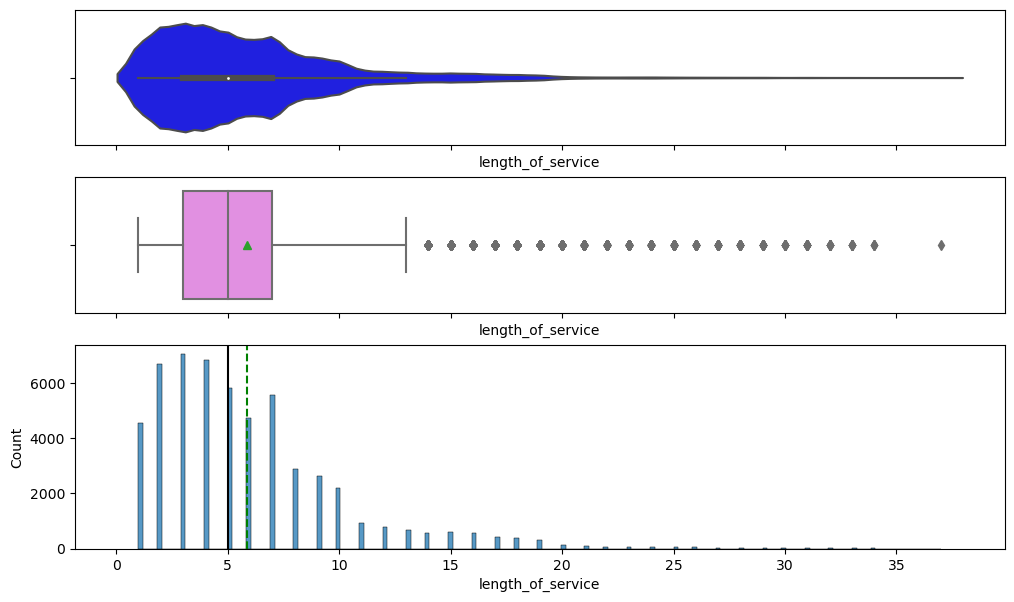

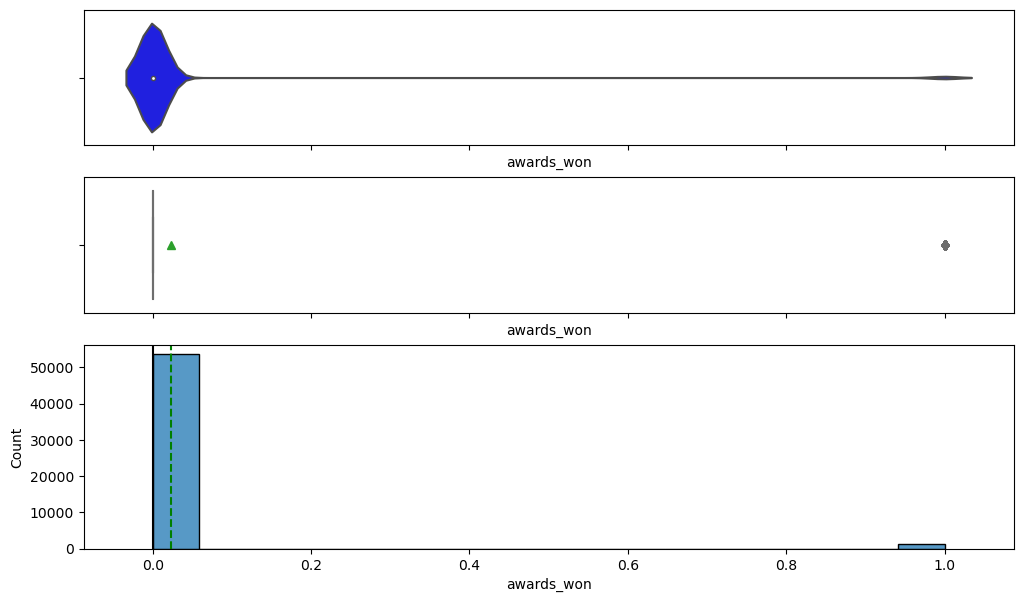

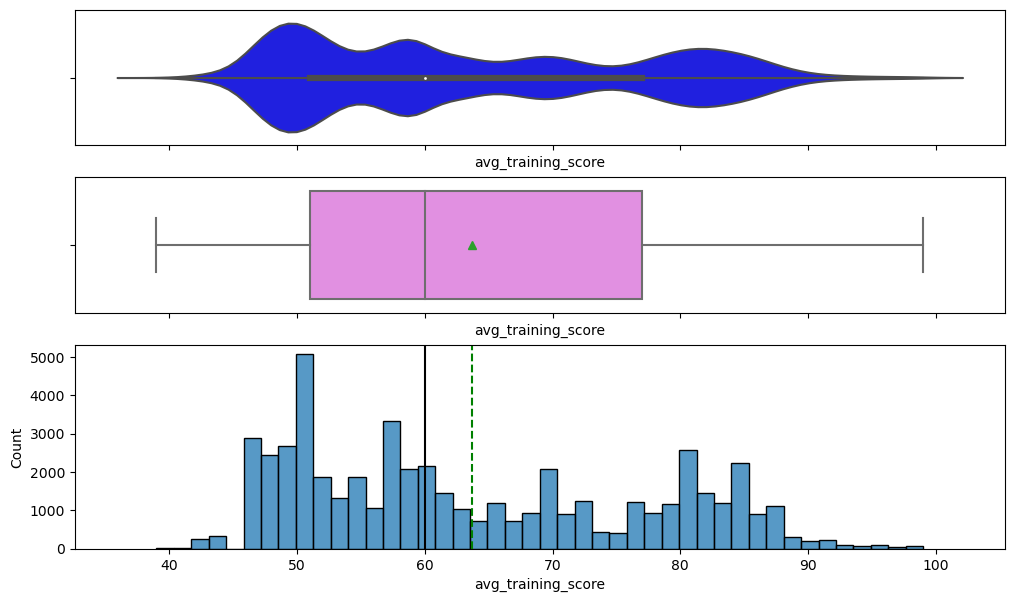

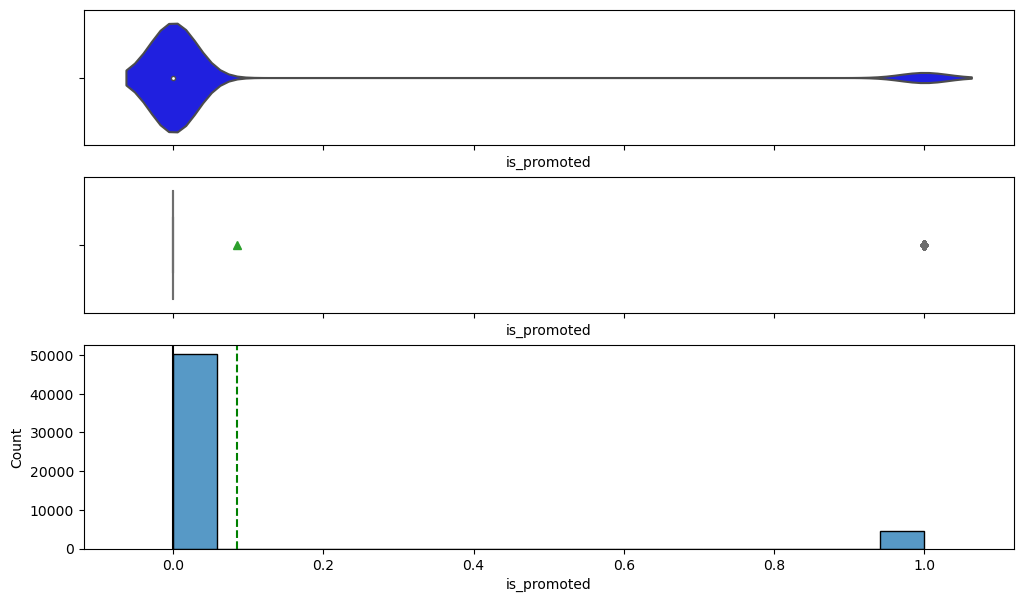

In [128]:
# selecting numerical columns
num_col = employee_df.select_dtypes(include=np.number).columns.tolist()

for item in num_col:
    histogram_boxplot(employee_df, item)

### Bivariate Analysis

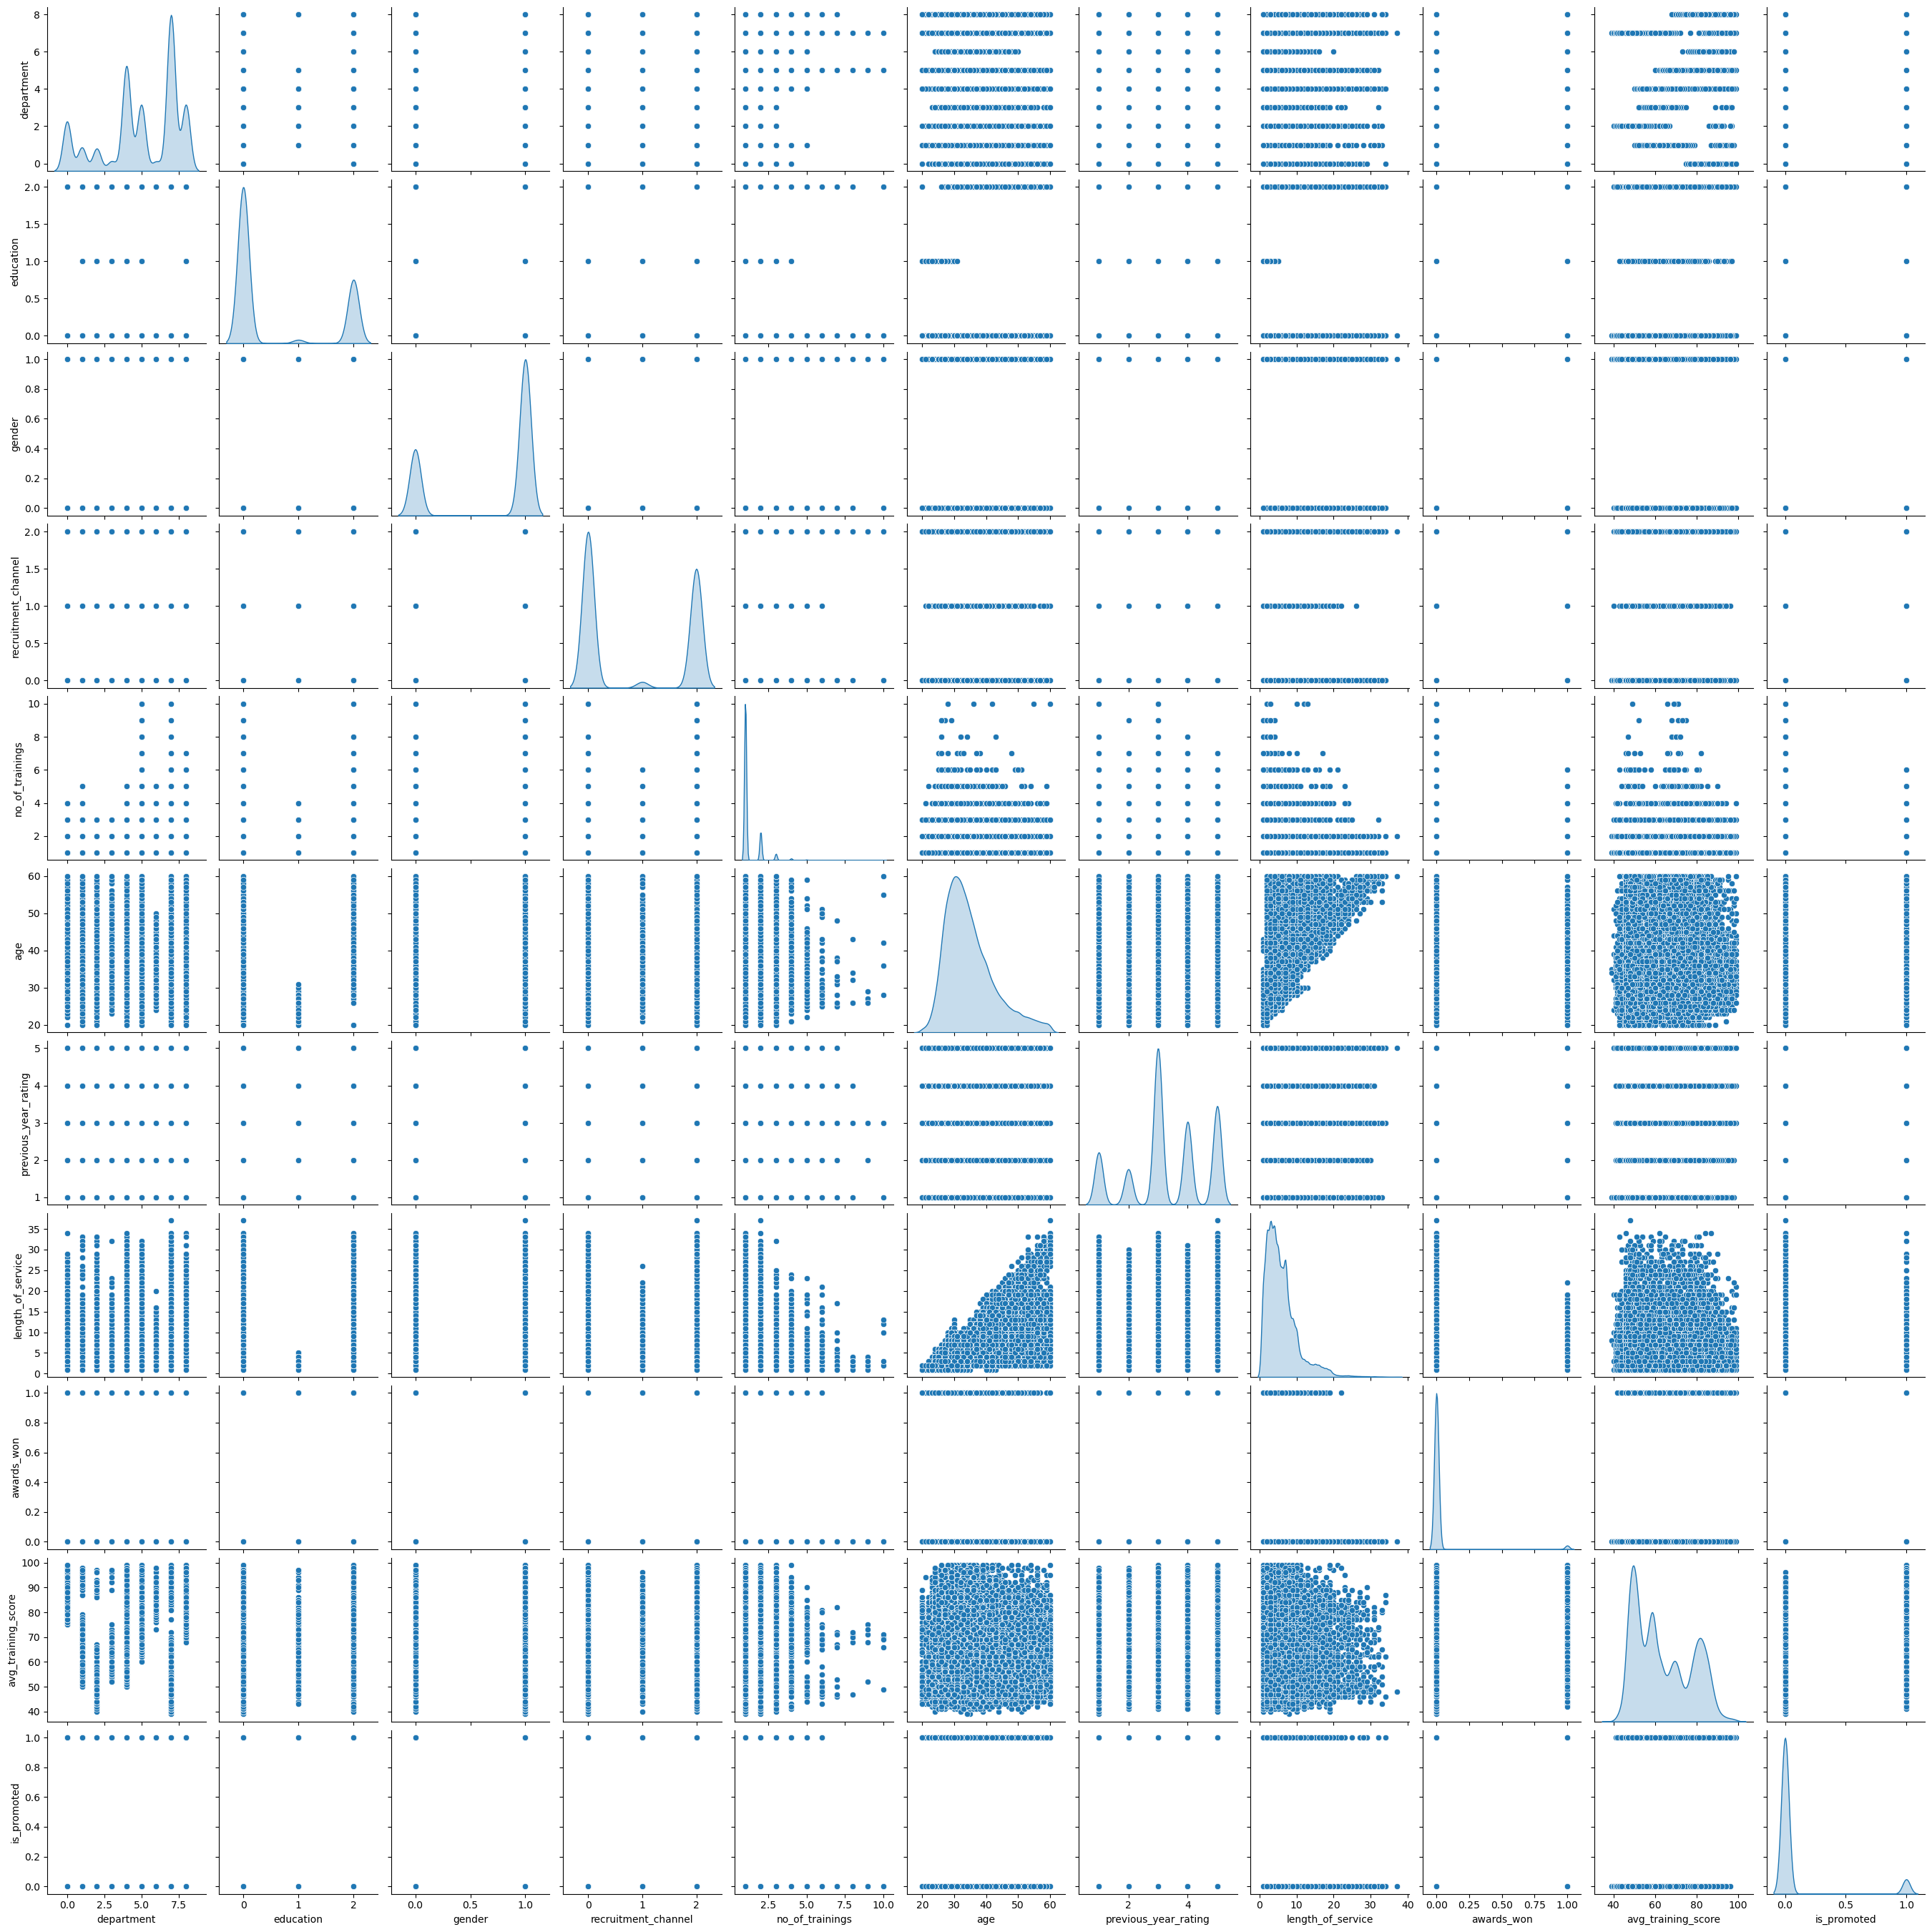

In [129]:
sns.pairplot(employee_df,diag_kind='kde')

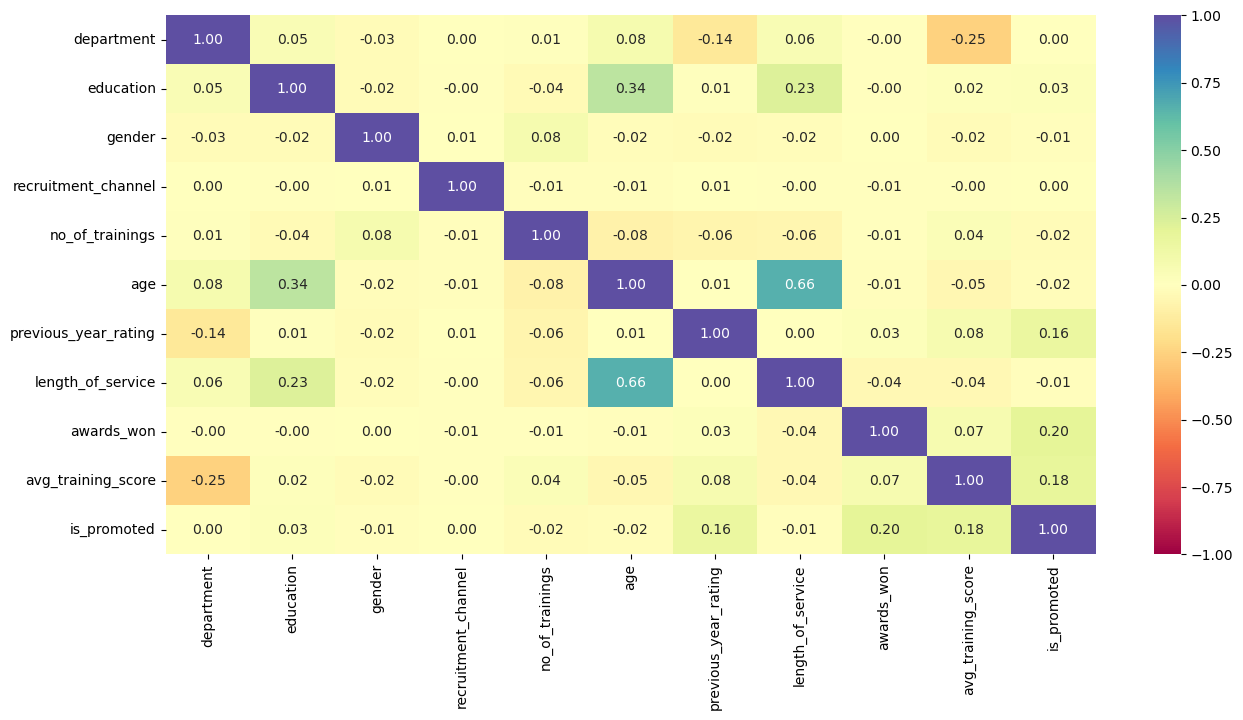

In [130]:
plt.figure(figsize=(15, 7))
sns.heatmap(employee_df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral")
plt.show()

## Outlier detection and handling

The quantile values for 25, 50 and 75 percentiles respectively for  department  are given by:
0.25    4.0
0.50    5.0
0.75    7.0
Name: department, dtype: float64
Resulting in an IQR of: 3.0
Leading to the respective lower and upper outer fences of -5.0 and 16.0


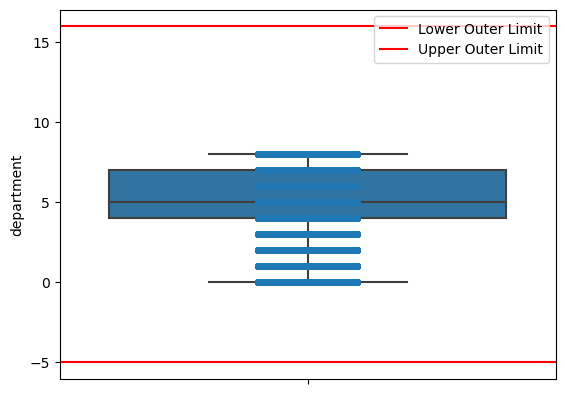

The quantile values for 25, 50 and 75 percentiles respectively for  education  are given by:
0.25    0.0
0.50    0.0
0.75    2.0
Name: education, dtype: float64
Resulting in an IQR of: 2.0
Leading to the respective lower and upper outer fences of -6.0 and 8.0


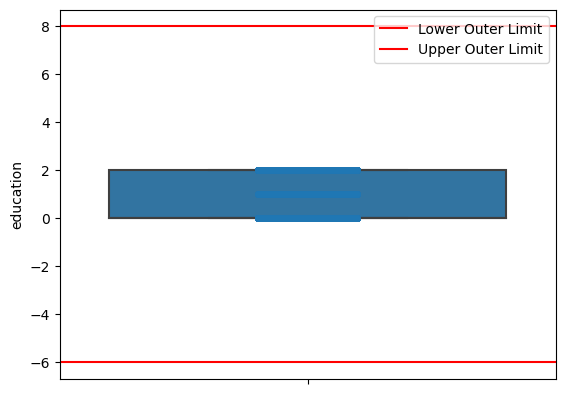

The quantile values for 25, 50 and 75 percentiles respectively for  gender  are given by:
0.25    0.0
0.50    1.0
0.75    1.0
Name: gender, dtype: float64
Resulting in an IQR of: 1.0
Leading to the respective lower and upper outer fences of -3.0 and 4.0


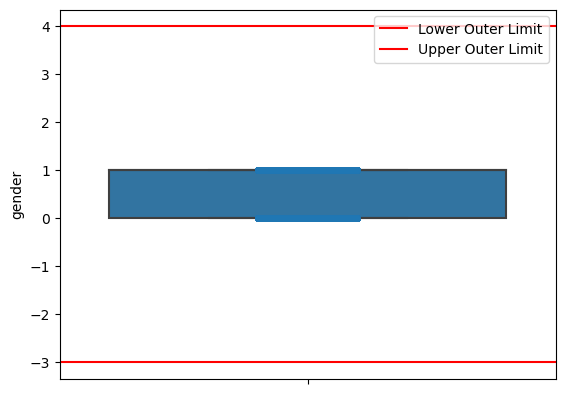

The quantile values for 25, 50 and 75 percentiles respectively for  recruitment_channel  are given by:
0.25    0.0
0.50    0.0
0.75    2.0
Name: recruitment_channel, dtype: float64
Resulting in an IQR of: 2.0
Leading to the respective lower and upper outer fences of -6.0 and 8.0


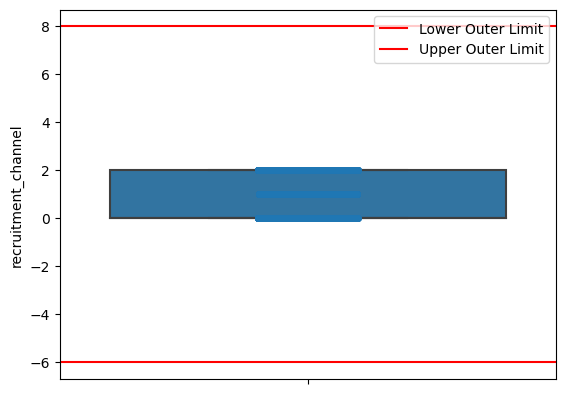

The quantile values for 25, 50 and 75 percentiles respectively for  no_of_trainings  are given by:
0.25    1.0
0.50    1.0
0.75    1.0
Name: no_of_trainings, dtype: float64
Resulting in an IQR of: 0.0
Leading to the respective lower and upper outer fences of 1.0 and 1.0


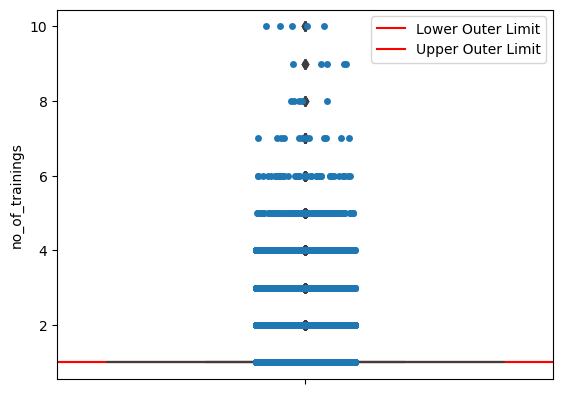

The quantile values for 25, 50 and 75 percentiles respectively for  age  are given by:
0.25    29.0
0.50    33.0
0.75    39.0
Name: age, dtype: float64
Resulting in an IQR of: 10.0
Leading to the respective lower and upper outer fences of -1.0 and 69.0


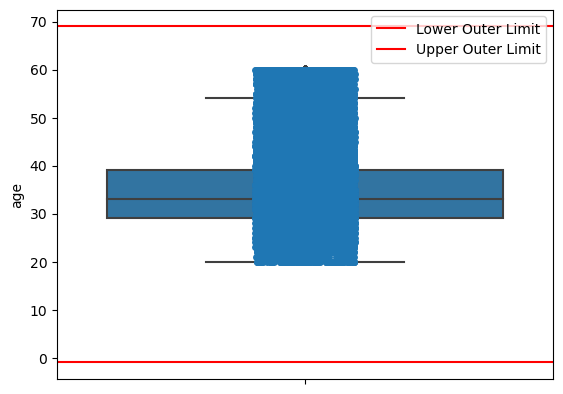

The quantile values for 25, 50 and 75 percentiles respectively for  previous_year_rating  are given by:
0.25    3.0
0.50    3.0
0.75    4.0
Name: previous_year_rating, dtype: float64
Resulting in an IQR of: 1.0
Leading to the respective lower and upper outer fences of 0.0 and 7.0


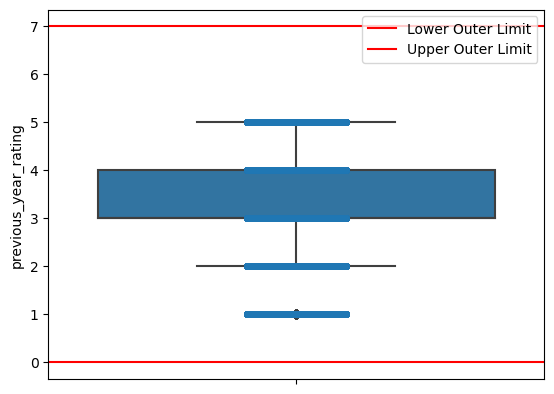

The quantile values for 25, 50 and 75 percentiles respectively for  length_of_service  are given by:
0.25    3.0
0.50    5.0
0.75    7.0
Name: length_of_service, dtype: float64
Resulting in an IQR of: 4.0
Leading to the respective lower and upper outer fences of -9.0 and 19.0


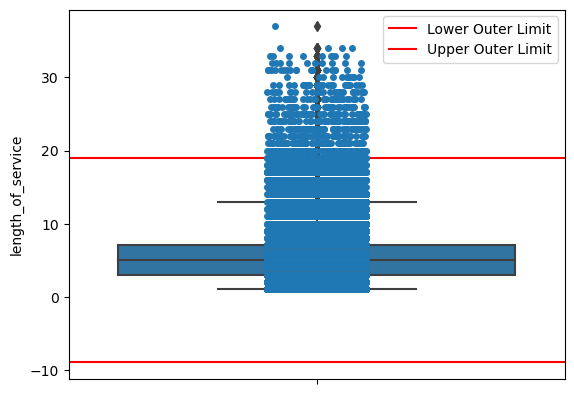

The quantile values for 25, 50 and 75 percentiles respectively for  awards_won  are given by:
0.25    0.0
0.50    0.0
0.75    0.0
Name: awards_won, dtype: float64
Resulting in an IQR of: 0.0
Leading to the respective lower and upper outer fences of 0.0 and 0.0


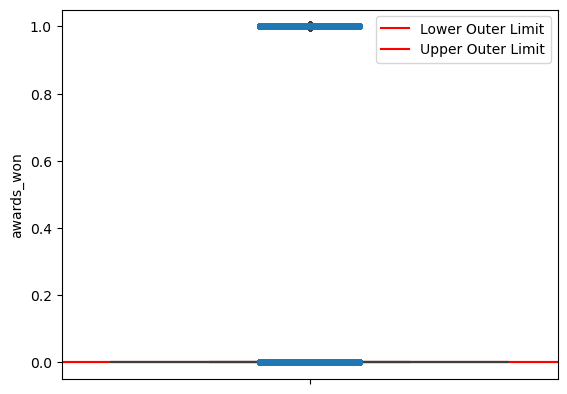

The quantile values for 25, 50 and 75 percentiles respectively for  avg_training_score  are given by:
0.25    51.0
0.50    60.0
0.75    77.0
Name: avg_training_score, dtype: float64
Resulting in an IQR of: 26.0
Leading to the respective lower and upper outer fences of -27.0 and 155.0


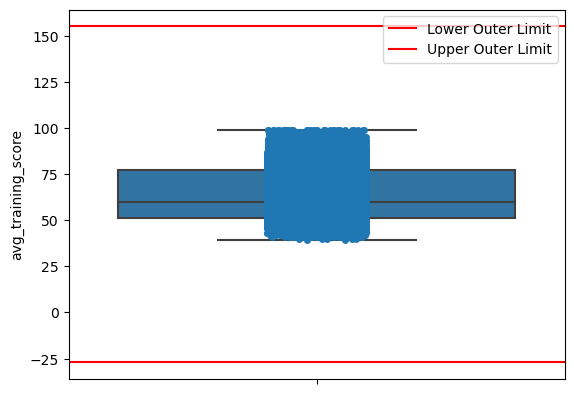

The quantile values for 25, 50 and 75 percentiles respectively for  is_promoted  are given by:
0.25    0.0
0.50    0.0
0.75    0.0
Name: is_promoted, dtype: float64
Resulting in an IQR of: 0.0
Leading to the respective lower and upper outer fences of 0.0 and 0.0


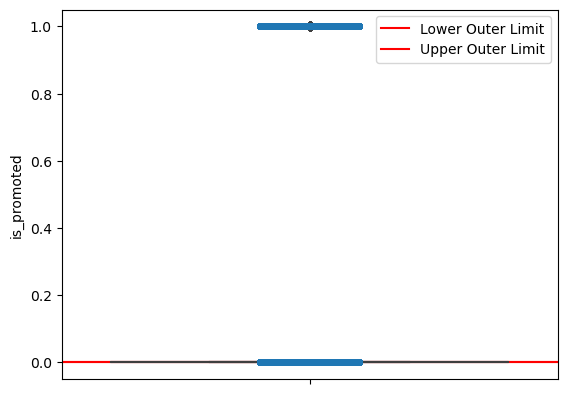

In [131]:
for n in employee_df.columns:
    quantile_data = employee_df[n].quantile([0.25,0.5,0.75])
    IQR = max(quantile_data.values)-min(quantile_data.values)
    low_out = min(quantile_data.values)-3*IQR
    upper_out = max(quantile_data.values)+3*IQR
    print('The quantile values for 25, 50 and 75 percentiles respectively for ',n,' are given by:')
    print(quantile_data)
    print('Resulting in an IQR of: '+str(IQR))
    print('Leading to the respective lower and upper outer fences of '+str(low_out)+' and '+str(upper_out))
    sns.boxplot(y = employee_df[n])
    sns.stripplot(y = employee_df[n])
    plt.axhline(y = low_out, color = 'r', linestyle = '-',label='Lower Outer Limit')
    plt.axhline(y = upper_out, color = 'r', linestyle = '-',label='Upper Outer Limit')
    plt.legend(bbox_to_anchor = (1.0, 1),loc = 'upper right')
    plt.show()

### Observations

## Prepping data for modeling

In [132]:
def null_val(df,flag=True):
    nan_vals = df.isna().sum().sort_values(ascending=False)
    nan_vals_perc = 100 * nan_vals/len(df)

    nan_val_df = pd.concat([nan_vals, nan_vals_perc.round(2).astype(str)+' %'], axis=1).reset_index()
    if flag == True:
        print(nan_val_df)
        
    return nan_val_df['index'].loc[nan_val_df[0]!=0].values

null_val(df)

                   index     0       1
0   previous_year_rating  4124  7.52 %
1     avg_training_score  2560  4.67 %
2              education  2409   4.4 %
3             department     0   0.0 %
4                 gender     0   0.0 %
5    recruitment_channel     0   0.0 %
6        no_of_trainings     0   0.0 %
7                    age     0   0.0 %
8      length_of_service     0   0.0 %
9             awards_won     0   0.0 %
10           is_promoted     0   0.0 %


array(['previous_year_rating', 'avg_training_score', 'education'],
      dtype=object)

In [133]:
df['education'].fillna(df['education'].mode()[0], inplace=True)
num_col_for_impute = ["previous_year_rating", "avg_training_score"]
imputer_num = SimpleImputer(strategy="median")
df[num_col_for_impute] = imputer_num.fit_transform(df[num_col_for_impute])

print('The remainding null values for data is:')
null_val(df)

The remainding null values for data is:
                   index  0      1
0             department  0  0.0 %
1              education  0  0.0 %
2                 gender  0  0.0 %
3    recruitment_channel  0  0.0 %
4        no_of_trainings  0  0.0 %
5                    age  0  0.0 %
6   previous_year_rating  0  0.0 %
7      length_of_service  0  0.0 %
8             awards_won  0  0.0 %
9     avg_training_score  0  0.0 %
10           is_promoted  0  0.0 %


array([], dtype=object)

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   department            54808 non-null  object 
 1   education             54808 non-null  object 
 2   gender                54808 non-null  object 
 3   recruitment_channel   54808 non-null  object 
 4   no_of_trainings       54808 non-null  int64  
 5   age                   54808 non-null  int64  
 6   previous_year_rating  54808 non-null  float64
 7   length_of_service     54808 non-null  int64  
 8   awards_won            54808 non-null  int64  
 9   avg_training_score    54808 non-null  float64
 10  is_promoted           54808 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 4.6+ MB


In [135]:
model_data = pd.get_dummies(df, drop_first=True)
model_data.head()

,no_of_trainings,age,previous_year_rating,length_of_service,awards_won,avg_training_score,is_promoted,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,education_Below Secondary,education_Master's & above,gender_m,recruitment_channel_referred,recruitment_channel_sourcing
0,1,35,5.0,8,0,49.0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
1,1,30,5.0,4,0,60.0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,1,34,3.0,7,0,50.0,0,0,0,0,0,0,0,1,0,0,0,1,0,1
3,2,39,1.0,10,0,50.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
4,1,45,3.0,2,0,73.0,0,0,0,0,0,0,0,0,1,0,0,1,0,0


## Null value handling

In [136]:
X = model_data.drop(["is_promoted"], axis=1)
y = model_data["is_promoted"]

# Splitting data into training, validation and test set for parameter tuning:

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=1, stratify=y_temp
)
print(X_train.shape, X_val.shape, X_test.shape)

(32884, 19) (10962, 19) (10962, 19)


In [137]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")    

Below I make a list of 6 prospective models that will be tested:

In [138]:
models = []  # Empty list to store all the models

# Models to use:
# Logistic Regression
models.append(("LR", LogisticRegression(random_state=1)))

# Decision trees
models.append(("DTC", DecisionTreeClassifier(random_state=1)))

# Ensemble models
models.append(("BC", BaggingClassifier(random_state=1)))
models.append(("RFC", RandomForestClassifier(random_state=1)))
models.append(("GBC", GradientBoostingClassifier(random_state=1)))
models.append(("ABC", AdaBoostClassifier(random_state=1)))


In [139]:
print("\n" "Training Performance with original data:" "\n")
for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_train, model.predict(X_train))
    print("{}: {}".format(name, scores))

print("\n" "Validation Performance with original data:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores_val = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores_val))


Training Performance with original data:

LR: 0.10392857142857143
DTC: 0.9342857142857143
BC: 0.8260714285714286
RFC: 0.9392857142857143
GBM: 0.29285714285714287
ABC: 0.16892857142857143

Validation Performance with original data:

LR: 0.11349036402569593
DTC: 0.38436830835117775
BC: 0.3340471092077088
RFC: 0.3029978586723769
GBM: 0.2965738758029979
ABC: 0.16381156316916487


Using the original data it becomes clear that models are highly overfitted. 

We test oversampling for training the models next:

In [140]:
sm = SMOTE(sampling_strategy=1, k_neighbors=4, random_state=1)  
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

print("Before Oversampling, counts of label 'Yes': {}".format(sum(y_train == 1)))
print("After Oversampling, counts of label 'Yes': {}".format(sum(y_train_over == 1)))
print("Before Oversampling, counts of label 'No': {} \n".format(sum(y_train == 0)))
print("After Oversampling, counts of label 'No': {} \n".format(sum(y_train_over == 0)))


print("\n" "Training Performance with oversampled data:" "\n")
for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_train_over, model.predict(X_train_over))
    print("{}: {}".format(name, scores))

print("\n" "Validation Performance with oversampled data:" "\n")

for name, model in models:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))

Before Oversampling, counts of label 'Yes': 2800
After Oversampling, counts of label 'Yes': 30084
Before Oversampling, counts of label 'No': 30084 

After Oversampling, counts of label 'No': 30084 


Training Performance with oversampled data:

LR: 0.7259340513229624
DTC: 0.9940167530913442
BC: 0.9879337854008775
RFC: 0.9960111687275628
GBM: 0.8117936444621726
ABC: 0.8036165403536764

Validation Performance with oversampled data:

LR: 0.48394004282655245
DTC: 0.3693790149892934
BC: 0.32012847965738755
RFC: 0.3511777301927195
GBM: 0.5064239828693791
ABC: 0.4550321199143469


Still highly overfitted models

In [141]:
rus = RandomUnderSampler(random_state=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

print("Before Undersampling, counts of label 'Yes': {}".format(sum(y_train == 1)))
print("After Undersampling, counts of label 'Yes': {}".format(sum(y_train_un == 1)))
print("Before Undersampling, counts of label 'No': {} \n".format(sum(y_train == 0)))
print("After Underampling, counts of label 'No': {} \n".format(sum(y_train_un == 0)))


print("\n" "Training Performance:" "\n")
for name, model in models:
    model.fit(X_train_un, y_train_un)
    scores = recall_score(y_train_un, model.predict(X_train_un))
    print("{}: {}".format(name, scores))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train_un, y_train_un)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))

Before Undersampling, counts of label 'Yes': 2800
After Undersampling, counts of label 'Yes': 2800
Before Undersampling, counts of label 'No': 30084 

After Underampling, counts of label 'No': 2800 


Training Performance:

LR: 0.6635714285714286
DTC: 0.9939285714285714
BC: 0.9603571428571429
RFC: 0.9960714285714286
GBM: 0.6271428571428571
ABC: 0.6635714285714286

Validation Performance:

LR: 0.6723768736616702
DTC: 0.645610278372591
BC: 0.5942184154175589
RFC: 0.6520342612419701
GBM: 0.6156316916488223
ABC: 0.6755888650963597


It seems that the Logistic Regression, Gradient Boosting Classifier and the AdaBoosting Classifier on undersampled data are the only ones that are not producing overfit models. Therefore we will move forward with these and tune them to hopefully get higher performance.

In [157]:
lr_model = LogisticRegression(random_state=1)

param_grid = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['none','l2','elasticnet'],
    'C':[0.01,0.1,1,10,100]

}

# Using F1 as balancing Recall and Precision is important in this case. False positives or false negatives will result in low morale, workflow hampering and eventual lose of revenue
scorer = metrics.make_scorer(metrics.f1_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=lr_model, param_distributions=param_grid, n_jobs = -1, n_iter=50, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'solver': 'newton-cg', 'penalty': 'none', 'C': 0.01} with CV score=0.6868530964413418:


In [158]:
tuned_lr = LogisticRegression(
    random_state=1,
    solver = 'newton-cg',
    penalty = 'none',
    C = 0.01
)
tuned_lr.fit(X_train_un, y_train_un)

# Checking model's performance on training set
lr_train = model_performance_classification_sklearn(tuned_lr, X_train_un, y_train_un)
display(lr_train)

# Checking model's performance on validation set
lr_val = model_performance_classification_sklearn(tuned_lr, X_val, y_val)
display(lr_val)

,Accuracy,Recall,Precision,F1
0,0.708571,0.653571,0.73435,0.69161


,Accuracy,Recall,Precision,F1
0,0.753147,0.658458,0.204863,0.3125


In [159]:
# Rinse and repeat for the other models
abc_model = AdaBoostClassifier(random_state=1)

param_grid = {
    "n_estimators": np.arange(10, 110, 10),
    "learning_rate": [0.1, 0.01, 0.2, 0.05, 1],
    "base_estimator": [
        DecisionTreeClassifier(max_depth=1, random_state=1),
        DecisionTreeClassifier(max_depth=2, random_state=1),
        DecisionTreeClassifier(max_depth=3, random_state=1),
        DecisionTreeClassifier(max_depth=None, random_state=1)
    ],
}

scorer = metrics.make_scorer(metrics.f1_score)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

randomized_cv = RandomizedSearchCV(estimator=abc_model, param_distributions=param_grid, n_jobs = -1, n_iter=50, scoring=scorer, cv=cv, random_state=1)

randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 80, 'learning_rate': 1, 'base_estimator': DecisionTreeClassifier(max_depth=1, random_state=1)} with CV score=0.6875464988848735:


In [170]:
tuned_abc = AdaBoostClassifier(
    random_state=1,
    n_estimators=80,
    learning_rate=1,
    base_estimator=DecisionTreeClassifier(max_depth=1, random_state=1),
)
tuned_abc.fit(X_train_un, y_train_un)


abc_train = model_performance_classification_sklearn(tuned_abc, X_train_un, y_train_un)
display(abc_train)

abc_val = model_performance_classification_sklearn(tuned_abc, X_val, y_val)
display(abc_val)

,Accuracy,Recall,Precision,F1
0,0.709286,0.68,0.722307,0.700515


,Accuracy,Recall,Precision,F1
0,0.73618,0.688437,0.198212,0.307803


In [160]:
# try again
gbc_model = GradientBoostingClassifier(random_state=1)


param_grid = {
    "init": [AdaBoostClassifier(random_state=1),DecisionTreeClassifier(random_state=1)],
    "n_estimators": np.arange(50,150,10),
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 1],
    "subsample":[0.5,0.7,1],
    "max_features":[0.5,0.7,1]
}


scorer = metrics.make_scorer(metrics.f1_score)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

randomized_cv = RandomizedSearchCV(estimator=gbc_model, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=cv, random_state=1, n_jobs = -1)


randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.5, 'n_estimators': 80, 'max_features': 0.7, 'learning_rate': 0.2, 'init': AdaBoostClassifier(random_state=1)} with CV score=0.6935726973565682:


In [167]:
tuned_gbc = GradientBoostingClassifier(
    random_state=1,
    n_estimators=80,
    learning_rate=0.2,
    subsample=0.5,
    max_features = 0.7,
    init = AdaBoostClassifier(random_state=1),
)
tuned_gbc.fit(X_train_un, y_train_un)


gbc_train = model_performance_classification_sklearn(tuned_gbc, X_train_un, y_train_un)
display(gbc_train)

gbc_val = model_performance_classification_sklearn(tuned_gbc, X_val, y_val)
display(gbc_val)

,Accuracy,Recall,Precision,F1
0,0.74875,0.676071,0.791057,0.729058


,Accuracy,Recall,Precision,F1
0,0.778416,0.647752,0.22366,0.332509


None of the models are performing at an acceptable level. They all provide minor improvements in accuracy at the expense of a huge decrease in precision. For that reason, XGradient Boost Classifier will be attempted.

In [164]:
# defining model
Model = XGBClassifier(random_state=1,eval_metric='logloss')

#Parameter grid to pass in RandomSearchCV
param_grid={'n_estimators':np.arange(50,300,50),
            'scale_pos_weight':[0,1,2,5,10],
            'learning_rate':[0.01,0.1,0.2,0.05],
            'gamma':[0,1,3,5],
            'subsample':[0.7,0.8,0.9,1]
           }

scorer = metrics.make_scorer(metrics.f1_score)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

randomized_cv = RandomizedSearchCV(estimator=Model, param_distributions=param_grid, n_iter=50, n_jobs = -1, scoring=scorer, cv=cv, random_state=1)

randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 2, 'n_estimators': 200, 'learning_rate': 0.1, 'gamma': 3} with CV score=0.4882281890070919:


In [169]:
tuned_xgbc = XGBClassifier(
    random_state=1,
    eval_metric="logloss",
    subsample=0.9,
    scale_pos_weight=2,
    n_estimators=200,
    learning_rate=0.01,
    gamma=3,
)


tuned_xgbc.fit(X_train_un, y_train_un)


xgbc_train = model_performance_classification_sklearn(tuned_xgbc, X_train_un, y_train_un)
display(xgbc_train)

xgbc_val = model_performance_classification_sklearn(tuned_xgbc, X_val, y_val)
display(xgbc_val)

,Accuracy,Recall,Precision,F1
0,0.645536,0.91,0.595188,0.719672


,Accuracy,Recall,Precision,F1
0,0.422459,0.900428,0.118802,0.209909


## Model Comparison

In [171]:
# Comparing the models on the validation data

models_val_comp_df = pd.concat(
    [lr_val.T, abc_val.T, gbc_val.T, xgbc_val.T], axis=1,
)
models_val_comp_df.columns = [
    "Logistic Regression trained with Undersampled data",
    "AdaBoost trained with Undersampled data",
    "Gradient boosting trained with Undersampled data",
    "XGBoost trained with Undersampled data",

]
print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,Logistic Regression trained with Undersampled data,AdaBoost trained with Undersampled data,Gradient boosting trained with Undersampled data,XGBoost trained with Undersampled data
Accuracy,0.753147,0.736180,0.778416,0.422459
Recall,0.658458,0.688437,0.647752,0.900428
Precision,0.204863,0.198212,0.223660,0.118802
F1,0.312500,0.307803,0.332509,0.209909


In [173]:
# Comparing the models on the testing data
lr_test = model_performance_classification_sklearn(tuned_lr, X_test, y_test)
abc_test = model_performance_classification_sklearn(tuned_abc, X_test, y_test)
gbc_test = model_performance_classification_sklearn(tuned_gbc, X_test, y_test)
xgbc_test = model_performance_classification_sklearn(tuned_xgbc, X_test, y_test)

models_test_comp_df = pd.concat(
    [lr_test.T, abc_test.T, gbc_test.T, xgbc_test.T], axis=1,
)
models_test_comp_df.columns = [
    "Logistic Regression trained with Undersampled data",
    "AdaBoost trained with Undersampled data",
    "Gradient boosting trained with Undersampled data",
    "XGBoost trained with Undersampled data",

]
print("Performance comparison on test data:")
models_test_comp_df

Performance comparison on test data:


,Logistic Regression trained with Undersampled data,AdaBoost trained with Undersampled data,Gradient boosting trained with Undersampled data,XGBoost trained with Undersampled data
Accuracy,0.757252,0.741014,0.781518,0.424101
Recall,0.648822,0.673448,0.641328,0.895075
Precision,0.206193,0.198862,0.225273,0.118565
F1,0.312936,0.307054,0.333426,0.209393


The F1 score for all models was extremely poor, given that the precision value was consistently poor for all models. This means that the model is extremely biased towards suggesting promotions to people that probably might not deserve it. Having so many false positives is an issue. Regardless, GradientBoosting is the one that performed the best. For the scope of this educational project, we will move on making a pipeline with this model for production. However, further feature engineering as well as implementation of Lasso Regression for regularization of the other models that produced highly overfitted samples could be an effective approach. 

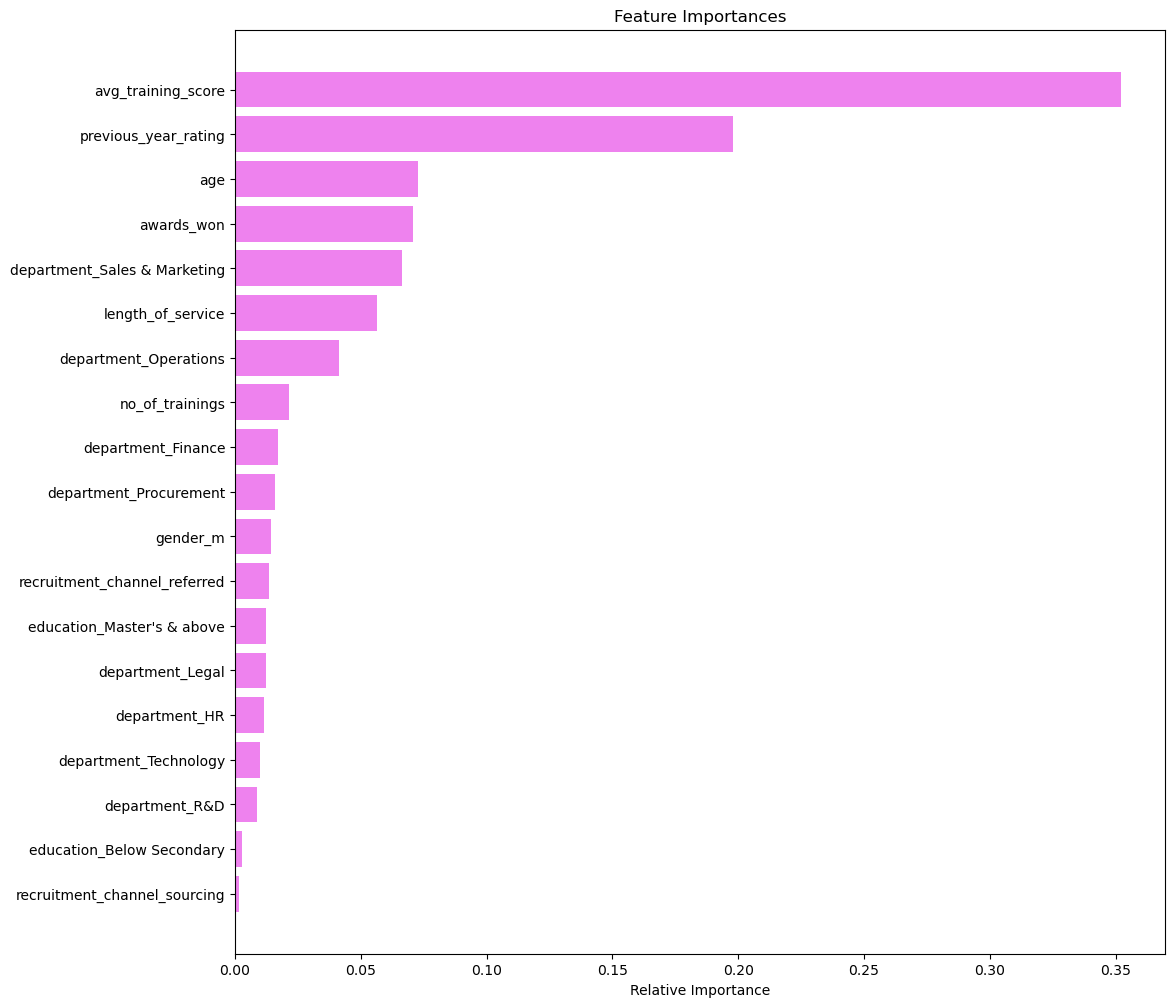

In [174]:
feature_names = X_train.columns
importances = tuned_gbc.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

avg_training_score is the most important variable in predicting adequacy of promotion followed by the rating of the previous year.

## Building a pipeline

In [191]:
# Separating target variable and other variables
X = df.drop(["is_promoted"], axis=1).copy()
y = df["is_promoted"].copy()
X.drop(columns=['employee_id','region'],inplace=True)

# creating a list of numerical variables
numerical_features = X.select_dtypes(include=np.number).columns

# creating a transformer for numerical variables, which will apply simple imputer on the numerical variables
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])


# creating a list of categorical variables
categorical_features = X.select_dtypes(include=object).columns

# creating a transformer for categorical variables, which will first apply simple imputer and 
#then do one hot encoding for categorical variables
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
        ]
                                    )
# handle_unknown = "ignore", allows model to handle any unknown category in the test data

# combining categorical transformer and numerical transformer using a column transformer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
                ]
                                )

# Creating new pipeline with best parameters
model = Pipeline(
    steps=[
        ("pre", preprocessor),
        ("GBM", GradientBoostingClassifier(
                random_state=1,
                n_estimators=80,
                learning_rate=0.2,
                subsample=0.5,
                max_features = 0.7,
                init = AdaBoostClassifier(random_state=1)
            )
        )
    ]
)

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1, stratify=y
)
print(X_train.shape, X_test.shape)
# Fit the model on training data
model.fit(X_train, y_train)


(41106, 10) (13702, 10)


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['no_of_trainings', 'age', 'previous_year_rating', 'length_of_service',
       'awards_won', 'avg_training_score'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['department', 'education', 'gender', 'recruitment_cha

## Business Recommendations

- The present predictive model will be effective in determining who should not get a promotion given that the recall value for the XGradientBoost Classifier was able to perform well.
  - The current model does not perform well to determine who should get promoted, given that this model produces too many false positives
  - Regularization of data could result in improvement of this model (however it is outside the scope of this assignment)
- Avg_training_score and previous_year_rating are the main factors that are correlated to promotion
  - Further feature engineering would substantially improve this data base. 
  - There are too many features that can objectively be shown to be/should be irrelevant to deciding a promotion